In [ ]:
!pip install -q kaggle

#Get kaggle.json from kaggle profile account under api section and upload it
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d carlolepelaars/camvid

Saving kaggle.json to kaggle.json
ref                                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/piterfm/2022-ukraine-russian-war                                 2022 Ukraine Russia War                              1KB  2022-03-26 22:24:46           2963        200  1.0              
datasets/prasertk/healthy-lifestyle-cities-report-2021                    Healthy Lifestyle Cities Report 2021                 2KB  2022-03-03 00:26:02           3044         97  1.0              
datasets/kamilpytlak/personal-key-indicators-of-heart-disease             Personal Key Indicators of Heart Disease             3MB  2022-02-16 10:18:03           4844         94 

In [ ]:
!unzip /content/camvid.zip

Archive:  /content/camvid.zip
  inflating: CamVid/class_dict.csv   
  inflating: CamVid/test/0001TP_006690.png  
  inflating: CamVid/test/0001TP_006720.png  
  inflating: CamVid/test/0001TP_006750.png  
  inflating: CamVid/test/0001TP_006780.png  
  inflating: CamVid/test/0001TP_006810.png  
  inflating: CamVid/test/0001TP_006840.png  
  inflating: CamVid/test/0001TP_006870.png  
  inflating: CamVid/test/0001TP_006900.png  
  inflating: CamVid/test/0001TP_006930.png  
  inflating: CamVid/test/0001TP_006960.png  
  inflating: CamVid/test/0001TP_006990.png  
  inflating: CamVid/test/0001TP_007020.png  
  inflating: CamVid/test/0001TP_007050.png  
  inflating: CamVid/test/0001TP_007080.png  
  inflating: CamVid/test/0001TP_007110.png  
  inflating: CamVid/test/0001TP_007140.png  
  inflating: CamVid/test/0001TP_007170.png  
  inflating: CamVid/test/0001TP_007200.png  
  inflating: CamVid/test/0001TP_007230.png  
  inflating: CamVid/test/0001TP_007260.png  
  inflating: CamVid/test/0001TP_

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, MaxPooling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from random import sample, choice
from PIL import Image
import numpy as np
import pandas as pd
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_img_lst = os.listdir("/content/CamVid/train")
val_img_lst = os.listdir("/content/CamVid/val")
test_img_lst = os.listdir("/content/CamVid/test")
print(len(train_img_lst),len(val_img_lst), len(test_img_lst))
print(type(train_img_lst[0].split('.')[0]))

369 100 232
<class 'str'>


In [ ]:
'''This function makes pairs of directories of Image and its mask '''
def make_pair(img_lst,image_dir,mask_dir):
    pairs = []
    #print(image_dir+img_lst[0])
    for im in img_lst:
        pairs.append((image_dir + '/' + im, mask_dir + '/'+ im.split('.')[0]+'_L.png'))
        
    return pairs

In [ ]:
'''Here we create lists of pairs of images and corresponding masks for both train and validation Images'''
train_pairs = make_pair(train_img_lst, "/content/CamVid/train", 
                        "/content/CamVid/train_labels")

val_pairs = make_pair(val_img_lst, "/content/CamVid/val", 
                        "/content/CamVid/val_labels")

test_pairs = make_pair(test_img_lst, "/content/CamVid/test", 
                        "/content/CamVid/test_labels")

test_pairs[0]

('/content/CamVid/test/Seq05VD_f01410.png',
 '/content/CamVid/test_labels/Seq05VD_f01410_L.png')

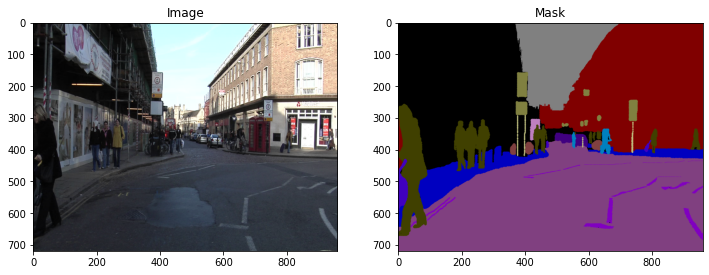

In [ ]:

temp = choice(train_pairs)
img = img_to_array(load_img(temp[0]))
mask = img_to_array(load_img(temp[1]))
#mask_pil = np.asarray(Image.open(temp[1]))

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title("Image")
plt.imshow(img/255)
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask/255)
#plt.subplot(123)
#plt.imshow(mask_pil)
plt.show()

In [ ]:
class_map_df = pd.read_csv("/content/CamVid/class_dict.csv")
class_map_df.head()

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0


In [ ]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
print(len(class_map))
print(class_map[0])

32
[ 64 128  64]


In [ ]:
'''This method will convert mask labels(to be trained) from RGB to a 2D image whic holds class labels of the pixels.'''
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [ ]:
classes = 32
def one_hot_masks(mask_file):
  stack_list = []

  # Reshape segmentation masks
  for c in range(classes):
    mask = tf.equal(mask_file[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
  
  one_hot_mask = tf.stack(stack_list, axis=2)
  return one_hot_mask

In [ ]:
lab = form_2D_label(mask,class_map)
lab = lab[...,np.newaxis]
ohe_mask = one_hot_masks(lab)
np.unique(lab,return_counts=True)

(array([ 2,  4,  5,  6,  8, 10, 12, 14, 16, 17, 19, 21, 27, 30],
       dtype=uint8),
 array([  2462, 146627,   2717,   3722,   1566,   7025,   7049,   2273,
         40329, 240195,  29925,  55047,   1247, 151016]))

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair,class_map,  batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = []
        batch_labels = []

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = label[...,tf.newaxis]
            ohe_label = one_hot_masks(label)
            #print(label.shape)
            batch_labels.append(ohe_label)
        return np.array(batch_imgs) ,np.array(batch_labels)

In [ ]:
img_size = 512

(4, 512, 512, 3) (4, 512, 512, 32)
Images


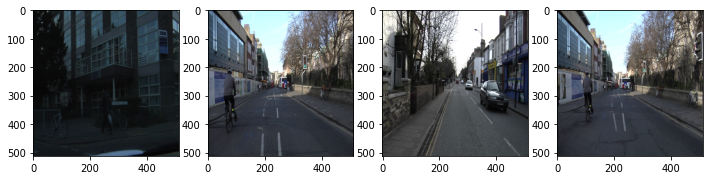

Masks


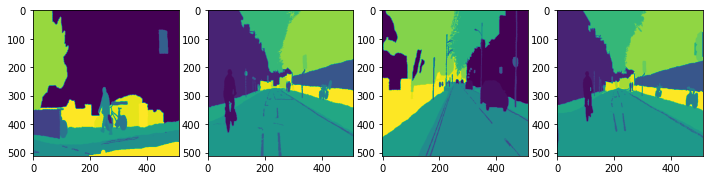

In [ ]:
img_size = 512

train_generator1 = DataGenerator(train_pairs,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
X,y = train_generator1.__getitem__(0)
print(X.shape, y.shape)
y = tf.argmax(y,axis=-1)

plt.figure(figsize=(12, 6))
print("Images")
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(X[i])
plt.show()

print("Masks")
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(y[i])
plt.show()

In [ ]:
train_generator = DataGenerator(train_pairs,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
val_generator = DataGenerator(val_pairs, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
test_generator = DataGenerator(test_pairs, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):

  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p

def encoder(inputs):
   
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [ ]:
def bottleneck(inputs):
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [ ]:

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):

  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)
  return outputs

In [ ]:
OUTPUT_CHANNELS = 32

def unet():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  inputs = tf.keras.layers.Input(shape=(512, 512,3,))

  encoder_output, convs = encoder(inputs)

  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instantiate the model
model = unet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
import keras.backend as K
def iou_metric(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return IoU

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=[iou_metric])

In [ ]:
mc = ModelCheckpoint(mode = 'max',filepath='weights.h5', monitor='val_iou_metric',save_best_only='True', verbose=1)
#es = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

In [ ]:
train_steps = train_generator.__len__()
val_steps = val_generator.__len__()

print(train_steps, val_steps)

92 25


In [ ]:
results = model.fit(train_generator , steps_per_epoch=train_steps ,epochs=20,
                              validation_data=val_generator,validation_steps=val_steps,callbacks=[mc],
                             verbose = 1)

Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: 1.9149 - iou_metric: 0.1812
Epoch 1: val_iou_metric improved from -inf to 0.30864, saving model to weights.h5
92/92 [==============================] - 525s 5s/step - loss: 1.9149 - iou_metric: 0.1812 - val_loss: 1.4443 - val_iou_metric: 0.3086
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: 1.3807 - iou_metric: 0.2903
Epoch 2: val_iou_metric did not improve from 0.30864
92/92 [==============================] - 475s 5s/step - loss: 1.3807 - iou_metric: 0.2903 - val_loss: 1.3790 - val_iou_metric: 0.2615
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: 1.2859 - iou_metric: 0.3119
Epoch 3: val_iou_metric improved from 0.30864 to 0.35735, saving model to weights.h5
92/92 [==============================] - 471s 5s/step - loss: 1.2859 - iou_metric: 0.3119 - val_loss: 1.1958 - val_iou_metric: 0.3573
Epoch 4/20
92/92 [==============================] - ETA: 0s - loss: 1.2127 - iou_metric: 0

In [ ]:
trained_model = tf.keras.models.load_model("/content/weights.h5",custom_objects={'iou_metric':iou_metric})

In [ ]:
trained_model.evaluate(test_generator, verbose=1)

58/58 [==============================] - 154s 3s/step - loss: 0.6819 - iou_metric: 0.5981


[0.6818592548370361, 0.5980942249298096]

In [ ]:
x_test, y_test = test_generator.__getitem__(0)
print(x_test.shape, y_test.shape)

(4, 512, 512, 3) (4, 512, 512, 32)


In [ ]:
y_pred = trained_model.predict(x_test, verbose = 1, batch_size = 4)
y_pred.shape

1/1 [==============================] - 0s 317ms/step


(4, 512, 512, 32)

In [ ]:
'''This converts predicted map to RGB labels'''
def map_this(y_pred,class_map):
    y_pred_rgb = np.zeros((y_pred.shape[0],y_pred.shape[1],y_pred.shape[2],3),dtype=int)
    for i in range(y_pred.shape[0]):
        image = np.zeros((y_pred.shape[1],y_pred.shape[2],3))
        for j in range(y_pred.shape[1]):
            for k in range(y_pred.shape[2]):
                image[j,k,:] = class_map[y_pred[i][j][k]]
        y_pred_rgb[i] = image
    return y_pred_rgb

In [ ]:
"""This will plot original image, original mask and predicted mask"""
def plot_result(img , title):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    for i in range(4):
        #print(pred[i].shape)
        plt.subplot(2, 4, i+1)
        plt.imshow(img[i])
    plt.show()

In [ ]:
integer_slider = 1
pred = np.argmax(y_pred, axis=3)
y_pred_rgb = map_this(pred,class_map)
y_test_rgb = map_this(np.argmax(y_test,axis=-1),class_map)

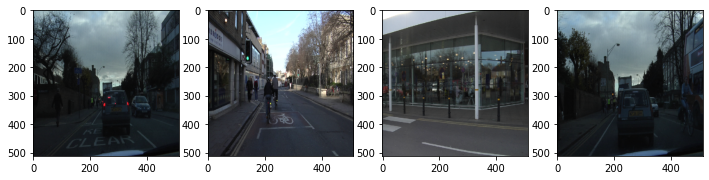

In [ ]:
plot_result(x_test,"Test Images")

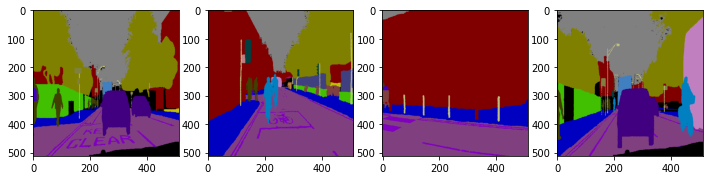

In [ ]:
plot_result(y_test_rgb,"Original Masks")

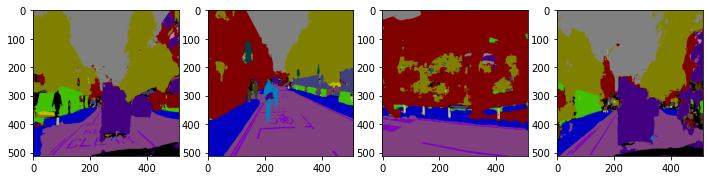

In [ ]:
plot_result(y_pred_rgb,"Predicted mask")

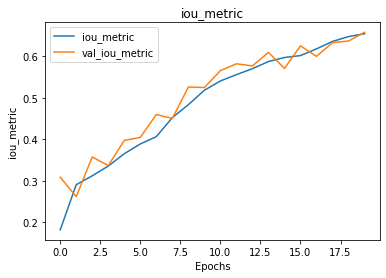

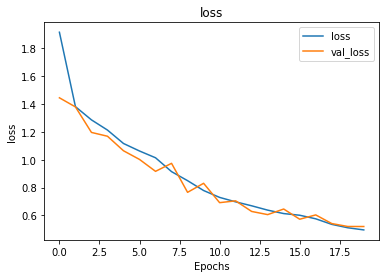

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(results, "iou_metric")
plot_graphs(results, "loss")